In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

In [2]:
def stop_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup stop
    Viene verificata il superamento del massimo (long) o minimo (short) sul level
    """
    service_dataframe = pd.DataFrame(index = dataframe.index)
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high

    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

def limit_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup limit
    Viene verificata il raggiungimento del minimo (long) o massimo (short) sul level
    """
    service_dataframe = pd.DataFrame()
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high
    
    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) & \
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

In [3]:
def marketposition_generator(enter_rules,exit_rules):
    """
    Funzione per calcolare il marketposition date due serie di enter_rules and exit_rules
    """
    service_dataframe = pd.DataFrame(index = enter_rules.index)
    service_dataframe['enter_rules'] = enter_rules
    service_dataframe['exit_rules'] = exit_rules
    
    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:
            if i == 1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)
        
    service_dataframe['mp_new'] = mp
    service_dataframe.mp_new = service_dataframe.mp_new.shift(1)
    service_dataframe.iloc[0,2] = 0
    service_dataframe.to_csv("marketposition_generator.csv")
    return service_dataframe.mp_new

In [4]:
def apply_trading_system(dataframe, bigpointvalue, tick, direction, order_type, 
                         enter_level, enter_rules, exit_rules):
    
    if ORDER_TYPE == "stop":
        enter_rules = stop_check(dataframe,enter_rules,enter_level,direction)
    if ORDER_TYPE == "limit":
        enter_rules = limit_check(dataframe,enter_rules,enter_level,direction)
        
    dataframe['enter_level'] = enter_level
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)
    
    dataframe["mp"] = marketposition_generator(dataframe.enter_rules,dataframe.exit_rules)
 
    if ORDER_TYPE == "market":
        dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                             dataframe.open, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / dataframe.open, np.nan)
    if ORDER_TYPE == "stop":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)   
    if ORDER_TYPE == "limit":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)                                                      
        
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    dataframe["events_in"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(1) == 0), "entry", "")
    if INSTRUMENT == 1:
        dataframe["number_of_stocks"] = dataframe["number_of_stocks"].apply(lambda x: round(x,0))\
                                        .fillna(method='ffill')
        
    if direction == "long":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                                    (dataframe.open.shift(-1) - dataframe.entry_price)
                                                    * dataframe.number_of_stocks - 2 * COSTS, 
                                                    dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.open.shift(-1) - dataframe.entry_price) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
            
    if direction == "short":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                            (dataframe.entry_price - dataframe.open.shift(-1))\
                                            * dataframe.number_of_stocks - 2 * COSTS,
                                            dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.entry_price - dataframe.open.shift(-1)) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
        
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0)
    dataframe["events_out"] = np.where((dataframe.mp == 1) & (dataframe.exit_rules == -1), "exit", "")      
    dataframe["operations"] = np.where((dataframe.exit_rules == -1) & (dataframe.mp == 1), 
                                        dataframe.open_operations, np.nan)
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    dataframe.to_csv("trading_system_export.csv")
    return dataframe

# Funzioni utilizzate:

In [5]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def load_data_intraday(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    data = pd.read_csv(filename, 
                       usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates=[['Date', 'Time']], )
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'],axis=1,inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    return data

def load_data_daily(filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    data = pd.read_csv(filename, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    return data
    
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))
        
def plot_equity(equity,color):
    """
    Funzione per stampare un'equity line
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def drawdown(equity):
    """
    Funzione che calcola il draw down data un'equity line
    """
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def plot_drawdown(equity,color):
    """
    Funzione per graficare la curva di draw down
    """
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def plot_double_equity(closed_equity,open_equity):
    """
    Funzione per stampare due equity sovrapposte
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red')
    plt.plot(closed_equity, color='green')
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def profit(equity):
    return round(equity[-1],2)

def profit1(operations):
    return round(operations.sum(),2)
    
def operation_number(operations):
    return operations.count()
    
def avg_trade(operations):
    return round(operations.mean(),2)
    
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)
    
def avgdrawdown_nozero(equity):
    """
    calcola la media del draw down storico
    non considerando i valori nulli (nuovi massimi di equity line)
    """
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

def avg_loss(operations):
    return round(operations[operations < 0].mean(),2)
    
def max_loss(operations):
    return round(operations.min(),2)
    
def max_loss_date(operations):
    return operations.idxmin()
    
def avg_gain(operations):
    return round(operations[operations > 0].mean(),2)
    
def max_gain(operations):
    return round(operations.max(),2)
    
def max_gain_date(operations):
    return operations.idxmax()
    
def gross_profit(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor(operations):
    a = gross_profit(operations)
    b = gross_loss(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)
        
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)
    
def reward_risk_ratio(operations):
    if operations[operations <= 0].mean() != 0:
        return round((operations[operations > 0].mean() / -operations[operations <= 0].mean()),2)
    else:
        return np.inf
        
def delay_between_peaks(equity):
    """
    Funzione per calcolare i ritardi istantanei in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else 0)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    #print(work_df.iloc[-20:,:])
    a = pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).cumsum())
    return a

def max_delay_between_peaks(equity):
    """
    Funzione per calcolare il più lungo ritardo in barre dall'ultimo massimo
    Input: equity line
    """
    a = delay_between_peaks(equity)
    return a.max()
    
def avg_delay_between_peaks(equity):
    """
    Funzione per calcolare il ritardo medio in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else np.nan)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    work_df.dropna(inplace = True)
    a = work_df['delay_elements'].groupby(work_df['cumsum']).sum()
    return round(a.mean(),2)
    
def plot_annual_histogram(operations):
    yearly = operations.resample('A').sum()
    colors = pd.Series()
    colors = yearly.apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(yearly)
    plt.subplots(figsize=(10, 7), dpi=200)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     yearly,
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Years')
    plt.ylabel('Profit - Loss')
    plt.title('Yearly Profit-Loss - by Gandalf Project R&D')
    plt.xticks(index, yearly.index.year, rotation=90)
    plt.grid(True)
    plt.show()
    return
    
def plot_monthly_bias_histogram(operations):
    monthly = pd.DataFrame(operations.fillna(0)).resample('M').sum()
    monthly['Month'] = monthly.index.month
    biasMonthly = []
    months = []

    for month in range(1, 13):
        months.append(month)
    for month in months:
        biasMonthly.append(monthly[(monthly['Month'] == month)].mean())

    biasMonthly = pd.DataFrame(biasMonthly)
    column = biasMonthly.columns[0]
    colors = pd.Series()
    colors = biasMonthly[column].apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(biasMonthly)
    plt.subplots(figsize=(14, 6), dpi=300)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     biasMonthly[column],
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Months')
    plt.ylabel('Average Profit - Loss')
    plt.title('Average Monthly Profit-Loss - by Gandalf Project R&D')
    months_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                    "October", "November", "December"]
    plt.xticks(index, months_names, rotation=45)
    plt.grid(True)
    plt.show()
    return
    
def plot_equity_heatmap(operations,annotations):
    monthly = operations.resample('M').sum()
    toHeatMap = pd.DataFrame(monthly)
    toHeatMap["Year"] = toHeatMap.index.year
    toHeatMap["Month"] = toHeatMap.index.month
    Show = toHeatMap.groupby(by=['Year','Month']).sum().unstack()
    Show.columns = ["January","February","March","April","May","June",
                    "July","August","September","October","November","December"]
    plt.figure(figsize=(8,6),dpi=120)
    sns.heatmap(Show, cmap="RdYlGn", linecolor="white", linewidth=0.1, annot=annotations, 
                vmin=-max(monthly.min(),monthly.max()), vmax=monthly.max())
    return
    
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance Report - by Gandalf Project R&D")
    print("")
    print("Profit:                  ", profit(open_equity))
    print("Operations:              ", operation_number(operations))
    print("Average Trade:           ", avg_trade(operations))
    print("")
    print("Profit Factor:           ", profit_factor(operations))
    print("Gross Profit:            ", gross_profit(operations))
    print("Gross Loss:              ", gross_loss(operations))
    print("")
    print("Percent Winning Trades:  ", percent_win(operations))
    print("Percent Losing Trades:   ", 100 - percent_win(operations))
    print("Reward Risk Ratio:       ", reward_risk_ratio(operations))
    print("")
    print("Max Gain:                ", max_gain(operations), " in date ", max_gain_date(operations))
    print("Average Gain:            ", avg_gain(operations))
    print("Max Loss:                ", max_loss(operations), " in date ", max_loss_date(operations))
    print("Average Loss:            ", avg_loss(operations))
    print("")
    print("Avg Open Draw Down:      ", avgdrawdown_nozero(open_equity))
    print("Max Open Draw Down:      ", max_draw_down(open_equity))
    print("")
    print("Avg Closed Draw Down:    ", avgdrawdown_nozero(trading_system.closed_equity))
    print("Max Closed Draw Down:    ", max_draw_down(trading_system.closed_equity))
    print("")
    print("Avg Delay Between Peaks: ", avg_delay_between_peaks(trading_system.open_equity))
    print("Max Delay Between Peaks: ", max_delay_between_peaks(trading_system.open_equity))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

import math

def tick_correction_up(level,tick):
    if level != level:
        level = 0
    multiplier = math.ceil(level/tick)
    return multiplier * tick

def tick_correction_down(level,tick):
    if level != level:
        level = 0
    multiplier = math.floor(level/tick)
    return multiplier * tick

In [6]:
def my_calmar_ratio(equity):
    """
    Il rapporto tra il guadagno finale e il max draw down registrato
    """
    netprofit = equity[-1]
    mdd = max_draw_down(equity)
    if mdd != 0:
        return round(netprofit / -mdd, 2)
    else:
        return np.inf
    
def my_calmar_ratio_yearly(operations,equity):
    """
    Il rapporto medio su base annuale tra
    il guadagno ed il draw down
    """
    yearly_operations = operations.resample('A').sum()
    yearly_drawdown = drawdown(equity).resample('A').min()
    records = []
    
    for i in range(len(yearly_operations)):
        if yearly_drawdown[i] != 0:
            records.append(-yearly_operations[i] / yearly_drawdown[i])
        else:
            records.append(np.inf)
            
    records = pd.Series(records, index = yearly_operations.index)
    return round(records.mean(),2), records

In [7]:
def my_sharpe_ratio(equity):
    """
    Il rapporto tra il guadagno totale 
    e la deviazione standard dell'equity line
    """
    netprofit = equity[-1]
    std = equity.std()
    if std != 0:
        return round(netprofit / std,2)
    else:
        return np.inf

def my_sharpe_ratio_yearly(operations):
    """
    Il rapporto medio su base annuale tra
    il guadagno e la deviazione standard
    """
    yearly_operations = operations.resample('A').sum()
    yearly_std = operations.resample('A').std()
    records = []
    
    for i in range(len(yearly_operations)):
        if yearly_std[i] != 0:
            records.append(yearly_operations[i] / yearly_std[i])
        else:
            records.append(np.inf)
            
    records = pd.Series(records, index = yearly_operations.index)
    
    return round(records.mean(),2), records

In [8]:
def my_kestner_ratio(operations):
    """
    Kestner Ratio versione 2003
    Una volta calcolata l'equity line dei contributi mensili delle operazioni aggregate
    calcoliamo la retta di regressione che meglio approssima lo sciame di punti 
    e riportiamo il rapporto tra la pendenza di tale retta e l'errore standard
    tra ogni punto e la retta medesima
    """
    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    monthly_operations = operations.resample('M').sum().fillna(0)
    monthly_equity = monthly_operations.cumsum()
    index = np.array(np.arange(1,monthly_operations.count() + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),4)
    else:
        return np.inf

# Motore di Ottimizzazione

In [11]:
opt_simulation = []
opt_parameter = []
opt_operations = []
opt_profit = []
opt_profit_factor = []
opt_avg_trade = []
opt_percent_win = []
opt_reward_risk_ratio = []
opt_max_draw_down = []
opt_avg_draw_down = []
opt_max_delay_between_peaks = []
opt_avg_delay_between_peaks = []
opt_calmar_ratio = []
opt_calmar_ratio_yearly = []
opt_sharpe_ratio = []
opt_sharpe_ratio_yearly = []
opt_kestner_ratio = []

data = load_data_daily("AAPL_Daily.txt")
dataset = data.copy()

dataset["llv"] = dataset.low.rolling(5).min()
    
COSTS = 0
INSTRUMENT = 1 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.01
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "market"
enter_level = dataset.open

min_period = 5
max_period = 50
opt_step = 5

optimization_fitness = "kr"
# "profit": profit
# "pf": profit_factor
# "at": avg_trade
# "pw": percent_win
# "rrr": reward_risk_ratio
# "mdd": maxdrawdown
# "add": avg_draw_down
# "adbp": avg_delay_between_peaks
# "cr": calmar_ratio
# "cry": calmar_ratio_yearly
# "sr": sharpe_ratio
# "sry": sharpe_ratio_yearly
# "kr": kestner_ratio

start_time = datetime.datetime.now()
print("optimization Process startet at:",start_time)
print("")
print("Optimization Steps:", int((max_period - min_period) / opt_step + 1))
print("")
print("Optimizing...")
print("")

print("simulation","opt1","operations","profit","pf","at","pw","rrr","mdd","add",
      "mddp","adbp","cr","cry","sr","sry","kr")

simulation_number = 1
for opt1 in range(min_period, max_period + opt_step, opt_step):

    dataset["hhv"] = dataset.high.rolling(opt1).max()
    
    enter_rules = crossover(dataset.close,dataset.hhv.shift(1))
    exit_rules = crossunder(dataset.close,dataset.llv.shift(1)) | (dataset.day < dataset.day.shift(1))
    
    trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                          enter_level, enter_rules, exit_rules)
    
    operations = trading_system.operations.dropna()
    if operations.count() > 0:
        opt_simulation.append(simulation_number)
        opt_parameter.append(opt1)
        opt_operations.append(operation_number(operations))
        opt_profit.append(profit(trading_system.open_equity))
        opt_profit_factor.append(profit_factor(operations))
        opt_avg_trade.append(avg_trade(operations))
        opt_percent_win.append(percent_win(operations))
        opt_reward_risk_ratio.append(reward_risk_ratio(operations))
        opt_max_draw_down.append(max_draw_down(trading_system.open_equity))
        opt_avg_draw_down.append(avgdrawdown_nozero(trading_system.open_equity))
        opt_max_delay_between_peaks.append(max_delay_between_peaks(trading_system.open_equity))
        opt_avg_delay_between_peaks.append(avg_delay_between_peaks(trading_system.open_equity))
        opt_calmar_ratio.append(my_calmar_ratio(trading_system.open_equity))
        opt_calmar_ratio_yearly.append(my_calmar_ratio_yearly(operations,trading_system.open_equity)[0])
        opt_sharpe_ratio.append(my_sharpe_ratio(trading_system.open_equity))
        opt_sharpe_ratio_yearly.append(my_sharpe_ratio_yearly(operations)[0])
        opt_kestner_ratio.append(my_kestner_ratio(operations))
        print(opt_simulation[-1],
              opt1, 
              operation_number(operations), 
              profit(trading_system.open_equity), 
              profit_factor(operations),
              avg_trade(operations),
              percent_win(operations), 
              reward_risk_ratio(operations),
              max_draw_down(trading_system.open_equity),
              avgdrawdown_nozero(trading_system.open_equity),
              max_delay_between_peaks(trading_system.open_equity),
              avg_delay_between_peaks(trading_system.open_equity),
              my_calmar_ratio(trading_system.open_equity),
              my_calmar_ratio_yearly(operations,trading_system.open_equity)[0], 
              my_sharpe_ratio(trading_system.open_equity),
              my_sharpe_ratio_yearly(operations)[0], 
              my_kestner_ratio(operations)
             )
    else: 
        print("Nessuna operazione registrata!")
        opt_parameter.append(opt1)
        opt_operations.append(0)
        opt_profit.append(0)
        opt_profit_factor.append(0)
        opt_avg_trade.append(0)
        opt_percent_win.append(0)
        opt_reward_risk_ratio.append(0)
        opt_max_draw_down.append(0)
        opt_avg_draw_down.append(0)
        opt_max_delay_between_peaks.append(0)
        opt_avg_delay_between_peaks.append(0)
        opt_calmar_ratio.append(0)
        opt_calmar_ratio_yearly.append(0)
        opt_sharpe_ratio.append(0)
        opt_sharpe_ratio_yearly.append(0)
        opt_kestner_ratio.append(0)
        
    simulation_number += 1
    
print("")
end_time = datetime.datetime.now()
print("Optimization elaborated in:", end_time - start_time)

optimization Process startet at: 2019-12-02 17:29:50.384069

Optimization Steps: 10

Optimizing...

simulation opt1 operations profit pf at pw rrr mdd add mddp adbp cr cry sr sry kr
1 5 249 31939.43 1.68 128.27 50.6 1.64 -5266.16 -1317.74 901 45.54 6.07 1.09 1.52 2.66 0.2425
2 10 203 30070.06 1.85 148.13 51.23 1.76 -4754.13 -1080.17 728 43.52 6.33 1.11 1.51 2.64 0.2927
3 15 166 35133.57 2.42 211.65 53.61 2.1 -3603.85 -940.12 707 39.2 9.75 1.54 1.56 3.06 0.2726
4 20 153 34583.66 2.64 226.04 56.86 2.0 -2830.35 -747.35 465 39.58 12.22 1.85 1.59 2.91 0.2731
5 25 140 32711.64 2.62 233.65 60.0 1.75 -2466.71 -726.41 489 39.03 13.26 1.77 1.55 2.83 0.2666
6 30 133 31601.64 2.84 237.61 60.15 1.88 -2466.71 -691.42 489 42.83 12.81 1.75 1.62 2.81 0.2941
7 35 129 29283.57 2.68 227.0 58.14 1.93 -2466.71 -700.0 489 44.36 11.87 1.56 1.59 2.44 0.2733
8 40 124 26851.73 2.49 216.55 56.45 1.92 -2524.51 -738.68 489 48.15 10.64 1.37 1.56 2.16 0.2593
9 45 121 25482.39 2.47 210.6 55.37 1.99 -2434.42 -749.88 52

In [18]:
opt_report = pd.DataFrame(list(zip(opt_simulation,
                                   opt_parameter,
                                   opt_operations, 
                                   opt_profit, 
                                   opt_profit_factor, 
                                   opt_avg_trade,
                                   opt_percent_win, 
                                   opt_reward_risk_ratio,
                                   opt_max_draw_down,
                                   opt_avg_draw_down,
                                   opt_max_delay_between_peaks,
                                   opt_avg_delay_between_peaks,
                                   opt_calmar_ratio,
                                   opt_calmar_ratio_yearly,
                                   opt_sharpe_ratio,
                                   opt_sharpe_ratio_yearly,
                                   opt_kestner_ratio)), 
                          columns = ["simulation",
                                     "opt",
                                     "operations",
                                     "profit",
                                     "pf",
                                     "at",
                                     "pw",
                                     "rrr",
                                     "mdd",
                                     "add",
                                     "mdbp",
                                     "adbp",
                                     "cr",
                                     "cry",
                                     "sr",
                                     "sry",
                                     "kr"])
opt_report.set_index("opt", inplace = True)
opt_report

,simulation,operations,profit,pf,at,pw,rrr,mdd,add,mdbp,adbp,cr,cry,sr,sry,kr
opt,,,,,,,,,,,,,,,,
5,1,249,31939.43,1.68,128.27,50.60,1.64,-5266.16,-1317.74,901,45.54,6.07,1.09,3.32,2.66,0.2425
10,2,203,30070.06,1.85,148.13,51.23,1.76,-4754.13,-1080.17,728,43.52,6.33,1.11,3.07,2.64,0.2927
15,3,166,35133.57,2.42,211.65,53.61,2.10,-3603.85,-940.12,707,39.20,9.75,1.54,3.22,3.06,0.2726
20,4,153,34583.66,2.64,226.04,56.86,2.00,-2830.35,-747.35,465,39.58,12.22,1.85,3.09,2.91,0.2731
25,5,140,32711.64,2.62,233.65,60.00,1.75,-2466.71,-726.41,489,39.03,13.26,1.77,2.99,2.83,0.2666
30,6,133,31601.64,2.84,237.61,60.15,1.88,-2466.71,-691.42,489,42.83,12.81,1.75,3.05,2.81,0.2941
35,7,129,29283.57,2.68,227.00,58.14,1.93,-2466.71,-700.00,489,44.36,11.87,1.56,2.98,2.44,0.2733
40,8,124,26851.73,2.49,216.55,56.45,1.92,-2524.51,-738.68,489,48.15,10.64,1.37,2.94,2.16,0.2593
45,9,121,25482.39,2.47,210.60,55.37,1.99,-2434.42,-749.88,528,50.25,10.47,1.34,2.95,1.88,0.2744


In [19]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__) # necessaria versione >= 1.9.0

import cufflinks as cf
# Per utilizzo con Notebooks
init_notebook_mode(connected=True)
# Per utilizzo offline
cf.go_offline()

opt_report["operations"].iplot(kind='line', color=["black"], title = "Operations - by Gandalf Project R&D")
opt_report["profit"].iplot(kind='line', color=["green"], title="Profit - by Gandalf Project R&D")
opt_report["pf"].iplot(kind='line', color=["blue"], title="Profit Factor - by Gandalf Project R&D")
opt_report["at"].iplot(kind='line', color=["green"], title="Average Trade - by Gandalf Project R&D")
opt_report["pw"].iplot(kind='line', color=["blue"], title="Percent Win - by Gandalf Project R&D")
opt_report["rrr"].iplot(kind='line', color=["blue"], title="Reward Risk Ratio - by Gandalf Project R&D")
opt_report["mdd"].iplot(kind='line', color=["red"], title="Max Draw Down - by Gandalf Project R&D")
opt_report["add"].iplot(kind='line', color=["red"], title="Average Draw Down Real - by Gandalf Project R&D")
opt_report["mdbp"].iplot(kind='line', color=["blue"], title="Max Delay Between Peaks - by Gandalf Project R&D")
opt_report["adbp"].iplot(kind='line', color=["blue"], title="Avg Delay Between Peaks - by Gandalf Project R&D")
opt_report["cr"].iplot(kind='line', color=["purple"], title="Calmar Ratio - by Gandalf Project R&D")
opt_report["cry"].iplot(kind='line', color=["purple"], title="Calmar Ratio Yearly - by Gandalf Project R&D")
opt_report["sr"].iplot(kind='line', color=["blue"], title="Sharpe Ratio - by Gandalf Project R&D")
opt_report["sry"].iplot(kind='line', color=["blue"], title="Sharpe Ratio Yearly - by Gandalf Project R&D")
opt_report["kr"].iplot(kind='line', color=["orange"], title="Kestner Ratio - by Gandalf Project R&D")

3.10.0


In [23]:
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance Report - by Gandalf Project R&D")
    print("")
    print("Profit:                  ", profit(open_equity))
    print("Operations:              ", operation_number(operations))
    print("Average Trade:           ", avg_trade(operations))
    print("")
    print("Profit Factor:           ", profit_factor(operations))
    print("Gross Profit:            ", gross_profit(operations))
    print("Gross Loss:              ", gross_loss(operations))
    print("")
    print("Percent Winning Trades:  ", percent_win(operations))
    print("Percent Losing Trades:   ", round(100 - percent_win(operations),2))
    print("Reward Risk Ratio:       ", reward_risk_ratio(operations))
    print("")
    print("Max Gain:                ", max_gain(operations), " in date ", max_gain_date(operations))
    print("Average Gain:            ", avg_gain(operations))
    print("Max Loss:                ", max_loss(operations), " in date ", max_loss_date(operations))
    print("Average Loss:            ", avg_loss(operations))
    print("")
    print("Avg Open Draw Down:      ", avgdrawdown_nozero(open_equity))
    print("Max Open Draw Down:      ", max_draw_down(open_equity))
    print("")
    print("Avg Closed Draw Down:    ", avgdrawdown_nozero(trading_system.closed_equity))
    print("Max Closed Draw Down:    ", max_draw_down(trading_system.closed_equity))
    print("")
    print("Avg Delay Between Peaks: ", avg_delay_between_peaks(trading_system.open_equity))
    print("Max Delay Between Peaks: ", max_delay_between_peaks(trading_system.open_equity))
    print("")
    print("Calmar Ratio:            ", my_calmar_ratio(trading_system.open_equity))
    print("Calmar Ratio Yearly:     ", my_calmar_ratio_yearly(operations,trading_system.open_equity)[0])
    print("Sharpe Ratio:            ", my_sharpe_ratio(trading_system.open_equity))
    print("Sharpe Ratio Yearly:     ", my_sharpe_ratio_yearly(operations)[0])   
    print("Kestner Ratio:           ", my_kestner_ratio(operations))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

Performance Report - by Gandalf Project R&D

Profit:                   32711.64
Operations:               140
Average Trade:            233.65

Profit Factor:            2.62
Gross Profit:             52854.58
Gross Loss:               -20142.94

Percent Winning Trades:   60.0
Percent Losing Trades:    40.0
Reward Risk Ratio:        1.75

Max Gain:                 2133.93  in date  2004-12-01 00:00:00
Average Gain:             629.22
Max Loss:                 -1020.26  in date  2007-11-08 00:00:00
Average Loss:             -359.7

Avg Open Draw Down:       -726.41
Max Open Draw Down:       -2466.71

Avg Closed Draw Down:     -624.68
Max Closed Draw Down:     -2074.67

Avg Delay Between Peaks:  39.03
Max Delay Between Peaks:  489

Calmar Ratio:             13.26
Calmar Ratio Yearly:      1.77
Sharpe Ratio:             3.0
Sharpe Ratio Yearly:      2.83
Kestner Ratio:            0.2666


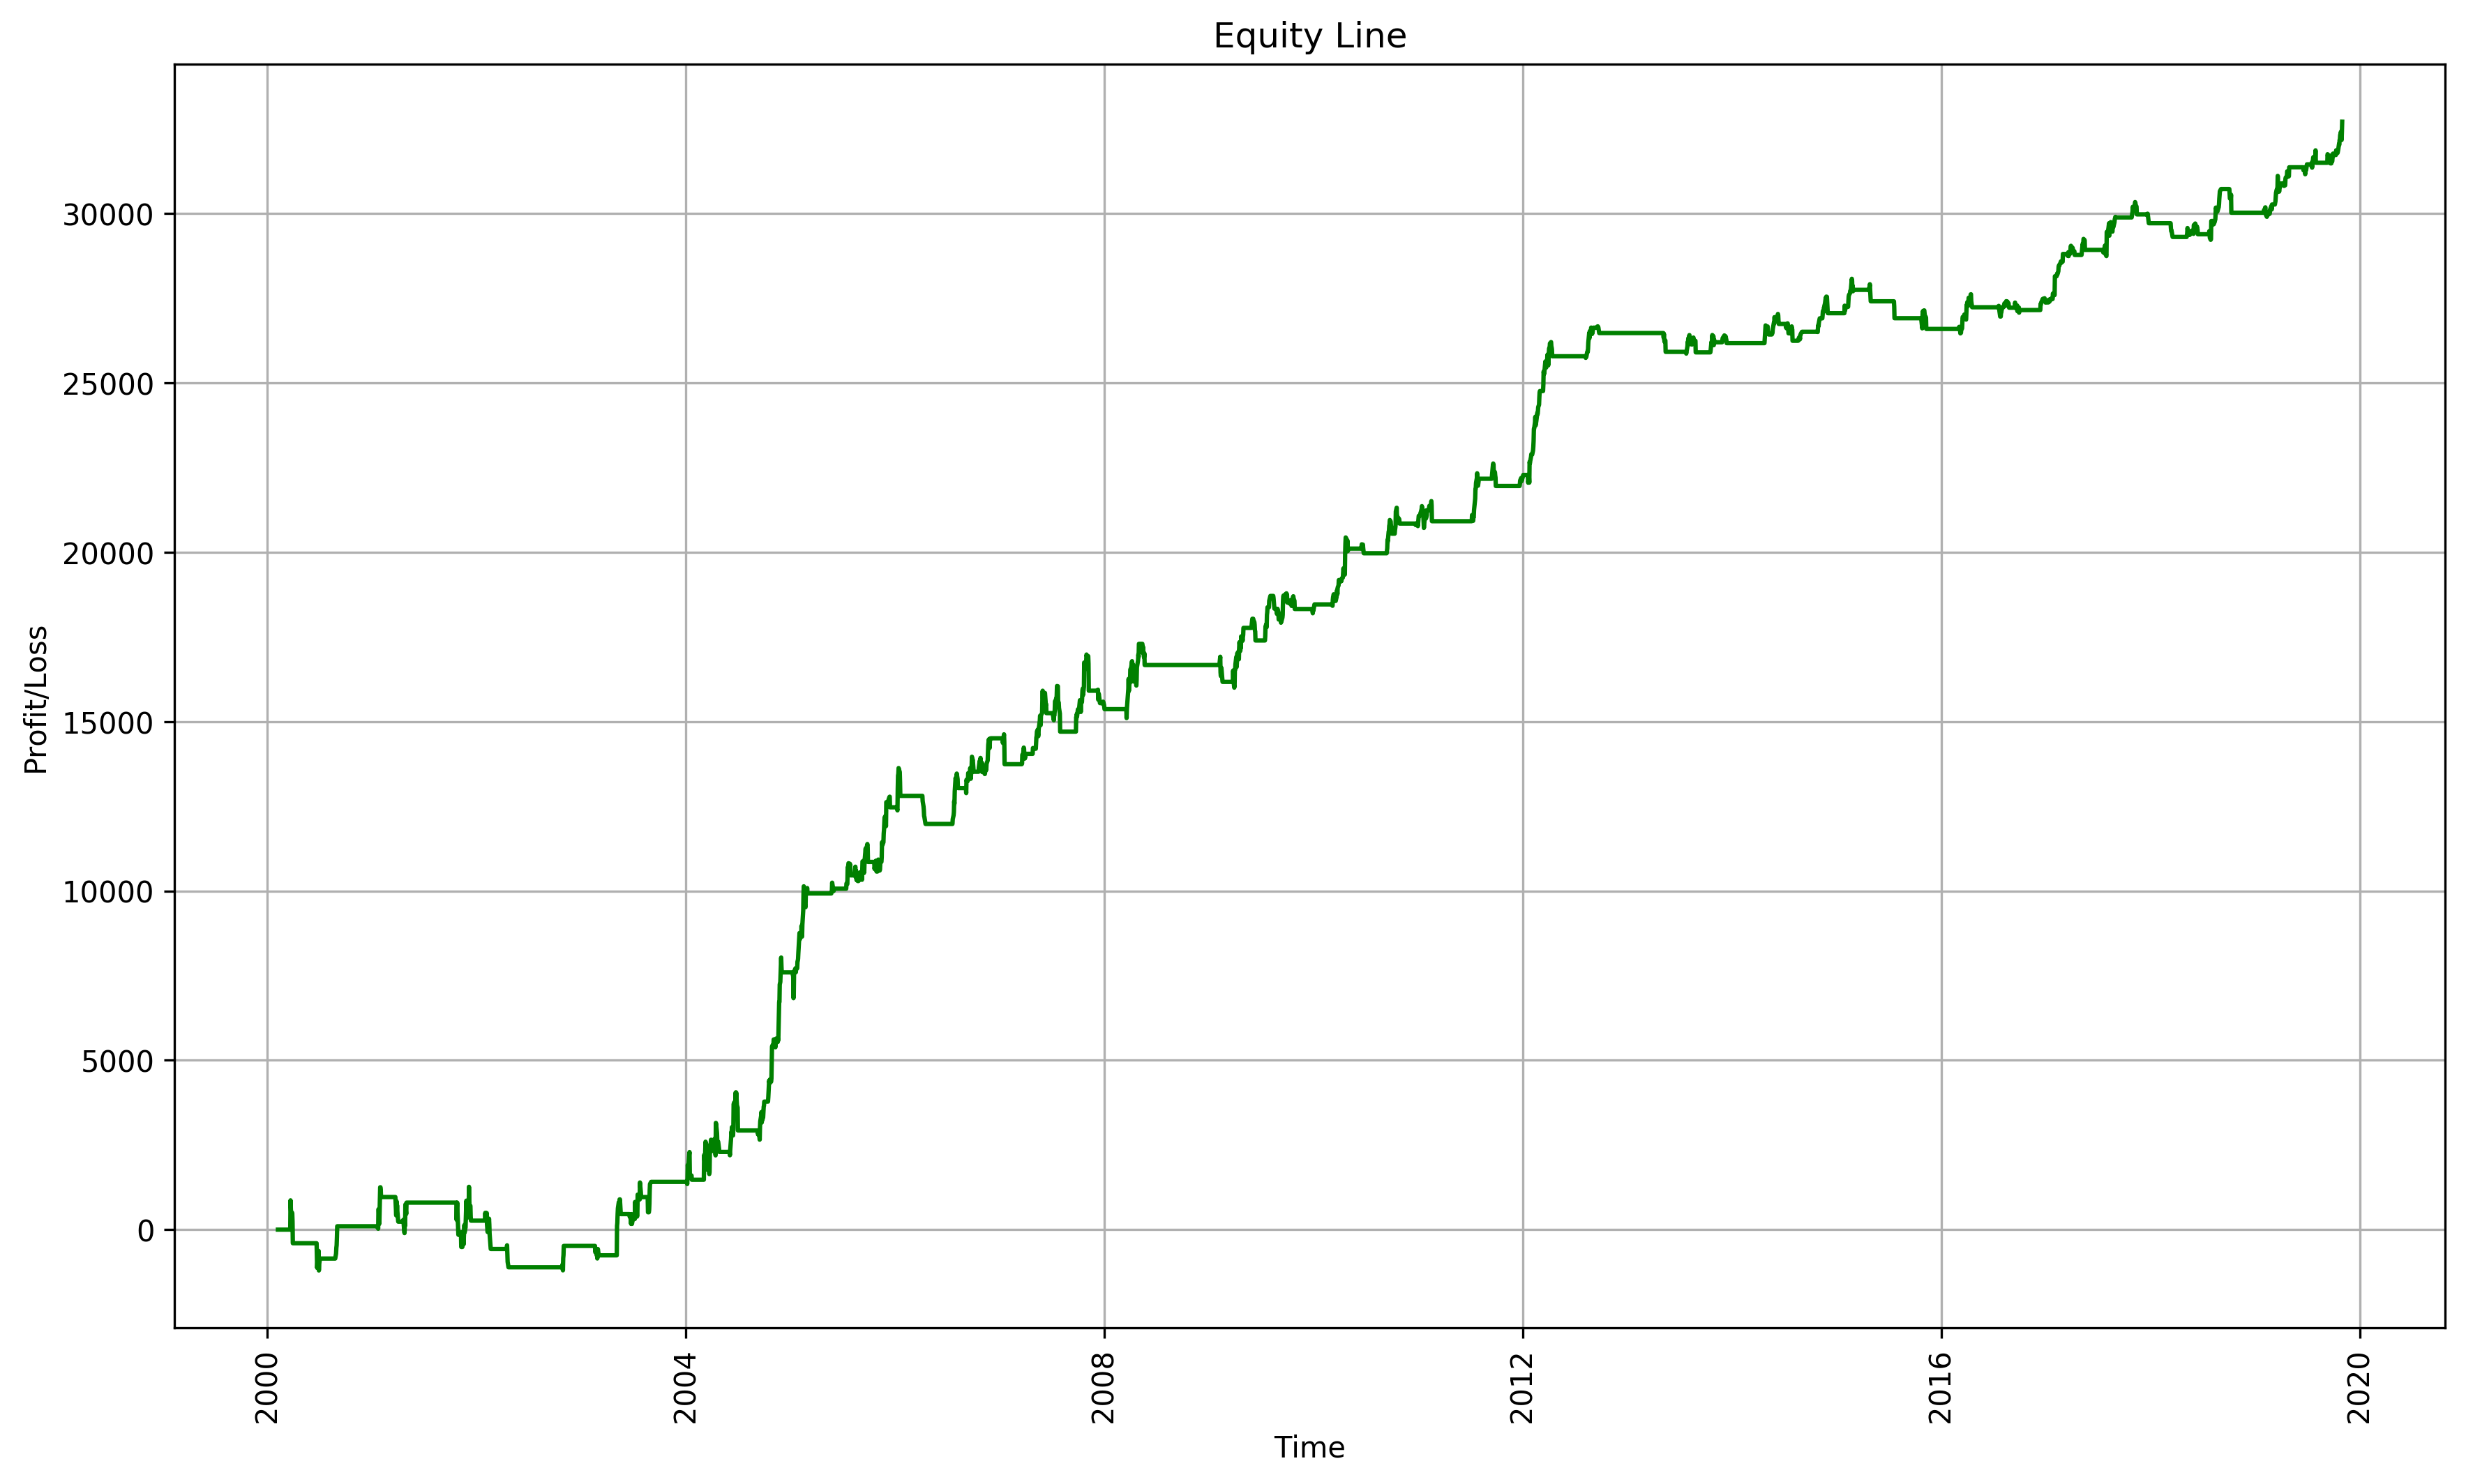

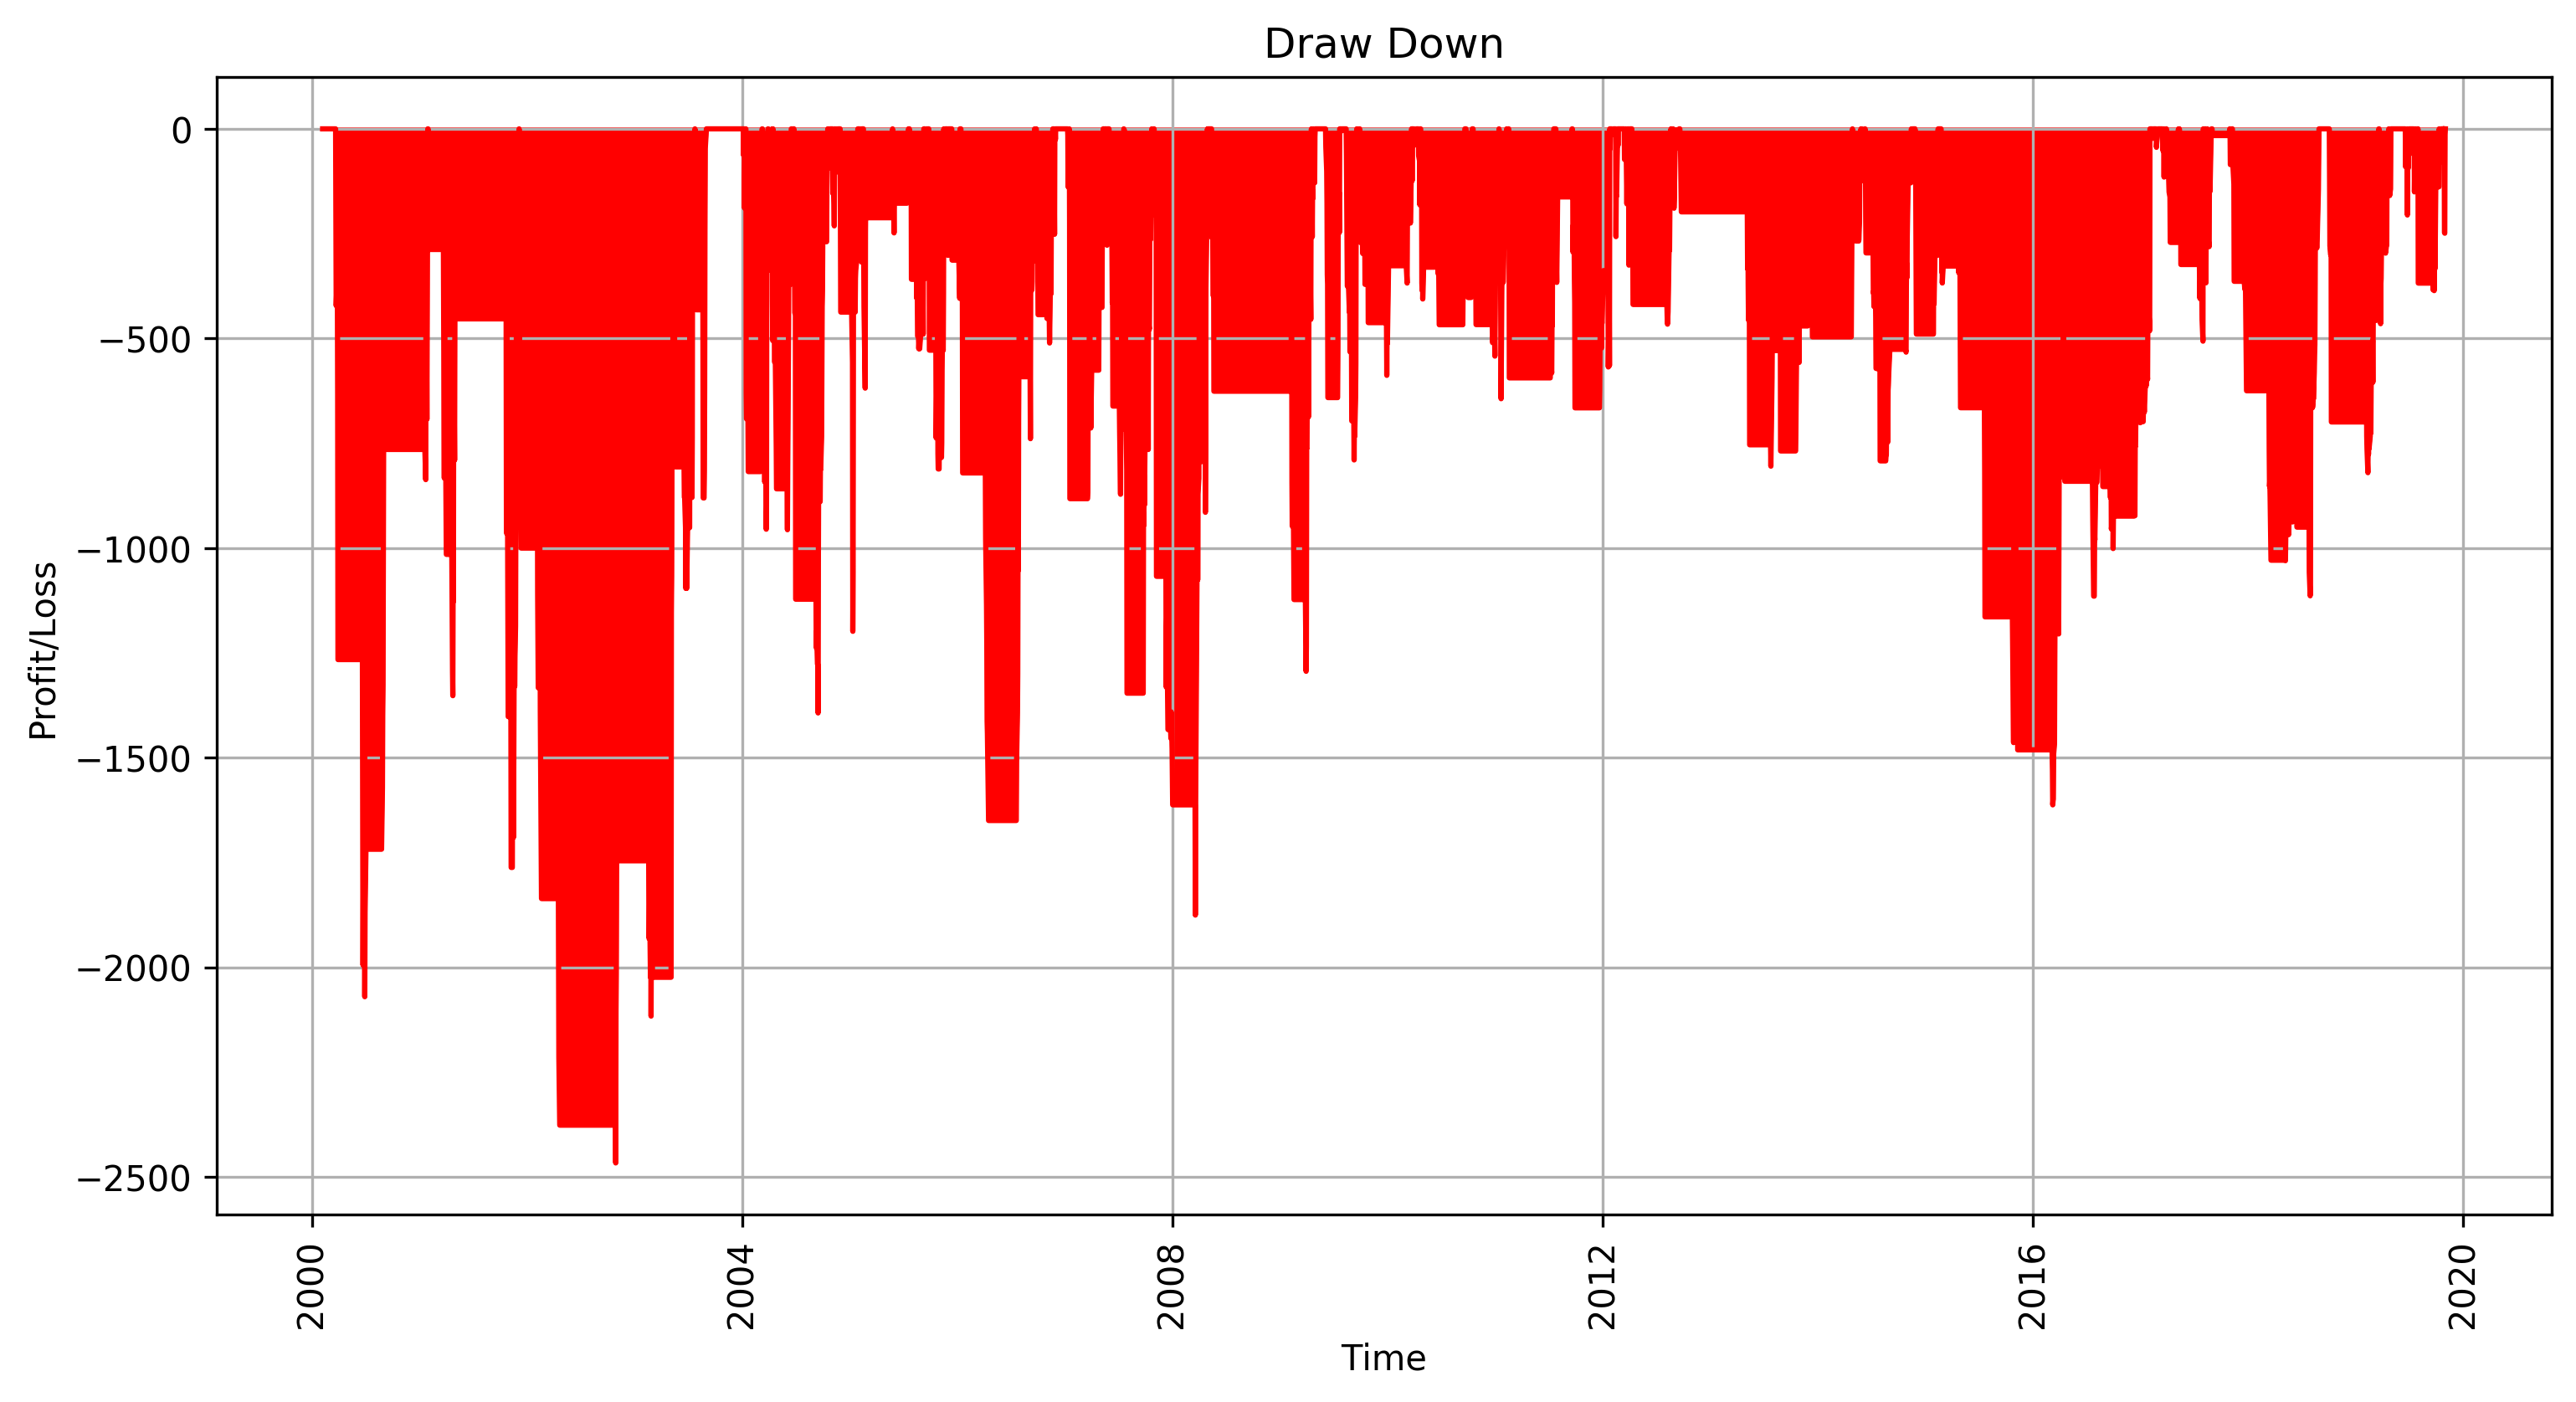

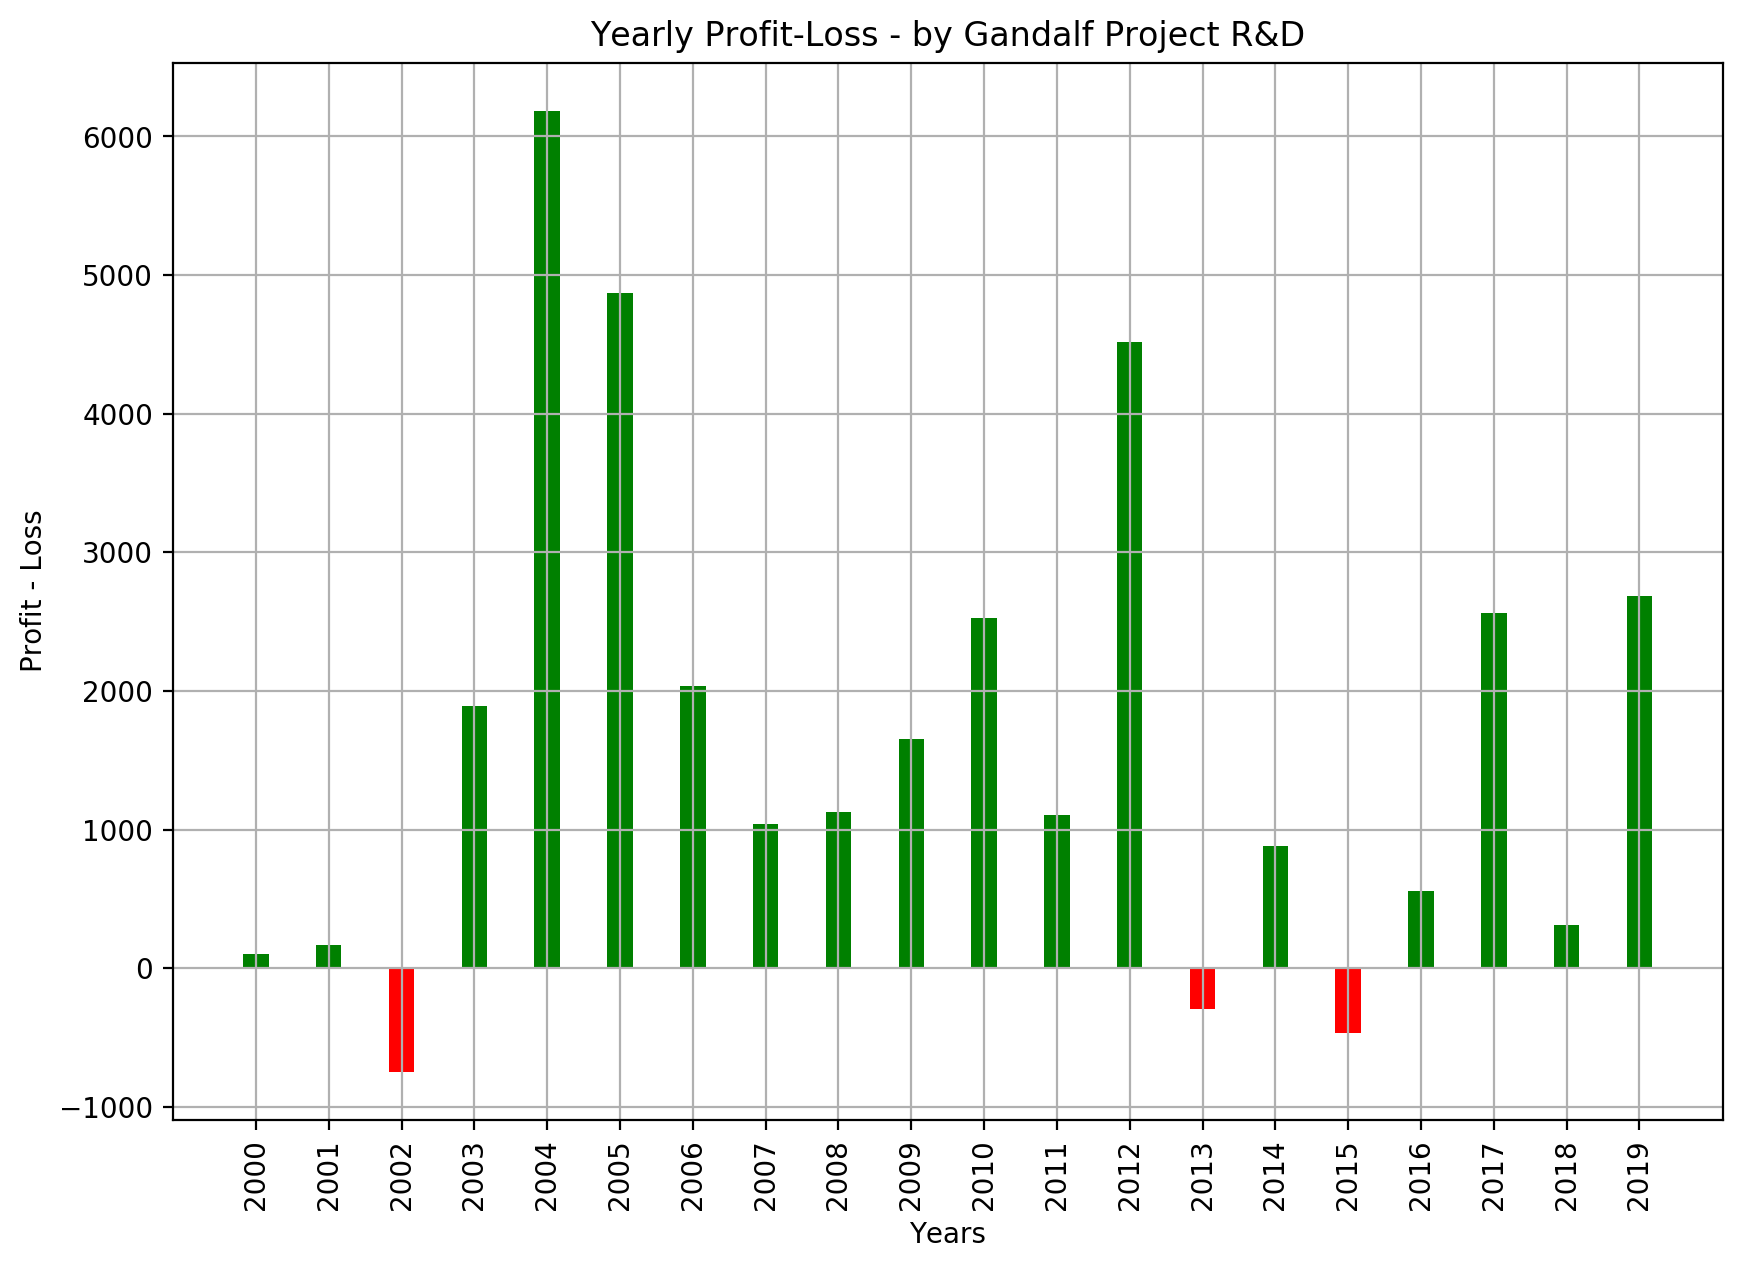

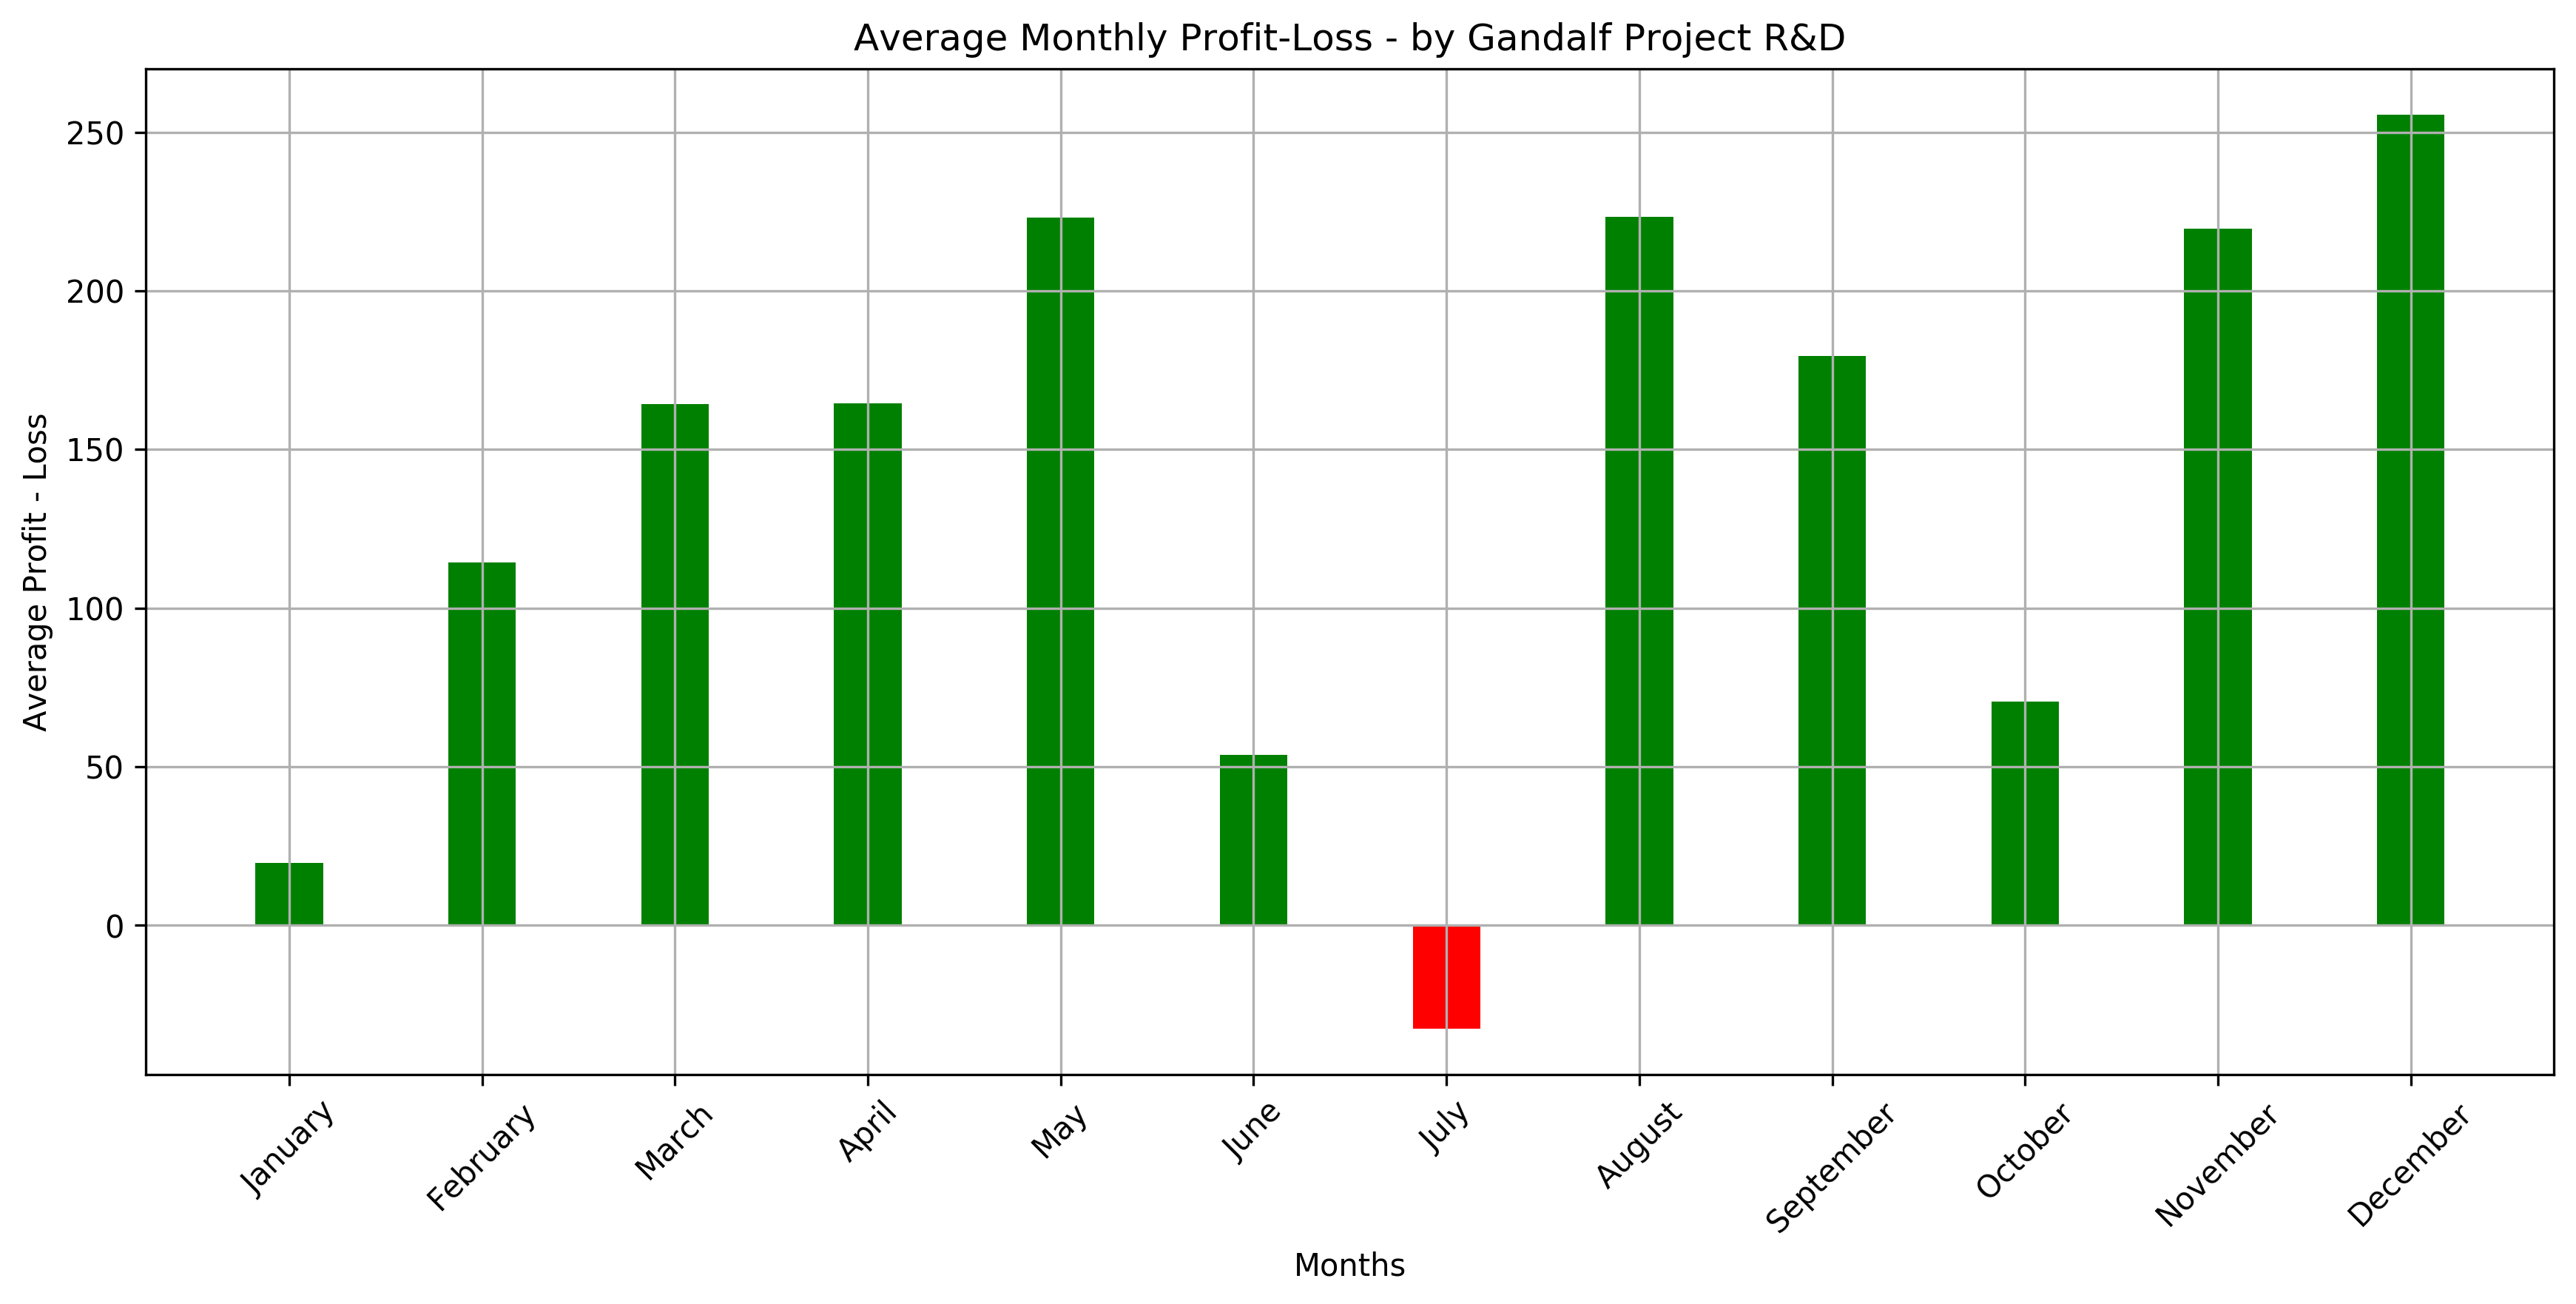

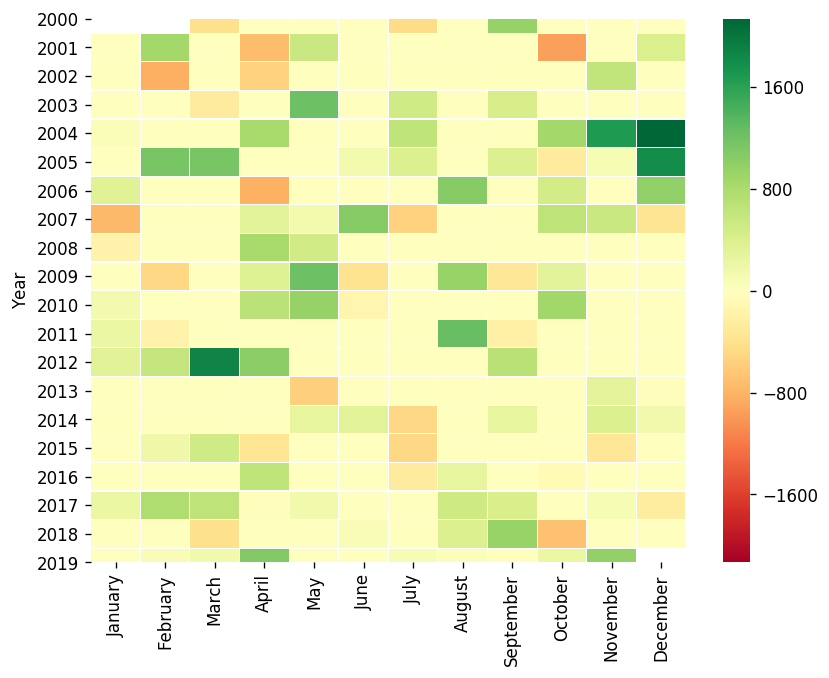

In [21]:
COSTS = 0
INSTRUMENT = 1 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.01
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "market"
enter_level = dataset.open

dataset = data.copy()

dataset["hhv"] = dataset.high.rolling(25).max()
dataset["llv"] = dataset.low.rolling(5).min()
dataset.dropna(inplace=True)

enter_rules = crossover(dataset.close,dataset.hhv.shift(1))

exit_rules = crossunder(dataset.close,dataset.llv.shift(1)) | (dataset.day < dataset.day.shift(1))

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system, operations,
                       trading_system.closed_equity, trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")